# Running a trained policy (test time task-agnostic control)

This notebook demonstrates how to execute a trained Play-LMP (or Play-GCBC) policy to achieve multiple goals.
See the original paper's section _Task-agnostic control at test time_ (Section 3.2) for details.

We begin by loading the normalization statistics and trained policy from disk, as specified in the Hydra configuration:

In [1]:
import equinox as eqx
import hydra
import jax
import jax.numpy as jnp
import mediapy
import numpy as np
import omegaconf
from jaxtyping import Array
from jaxtyping import PyTree

from play_lmp.play_lmp import PlayLMP
from play_lmp.preprocessing import postprocess_action
from play_lmp.preprocessing import preprocess_observation
from train import get_model
from train import get_normalization_stats


cfg = omegaconf.OmegaConf.load("conf/config.yaml")
observation_stats, action_stats = get_normalization_stats(cfg, None)
target_action_range = jnp.stack(
    [
        hydra.utils.instantiate(cfg.model.target_action_max),
        hydra.utils.instantiate(cfg.model.target_action_min),
    ]
)
target_max, target_min = target_action_range
model = get_model(cfg.model, cfg.training.method, jax.random.PRNGKey(0))
model = eqx.nn.inference_mode(
    eqx.tree_deserialise_leaves(cfg.training.evaluation.model_save_path, model)
)

To provide multiple goals to the policy in sequence, we use a validation trajectory from the CALVIN environment D dataset.
We will specify the relative strides of the target states (`GOAL_STEP_STRIDES`), as well as the number of timesteps to run the policy for before switching to the next goal (`GOAL_SWITCH_STRIDES`):

In [2]:
VAL_DATASET_PATH = "calvin/dataset/task_D_D/validation/"
VAL_EPISODE_IDX = 0
START_STEP = 6000
GOAL_STEP_STRIDES = [64, 40, 60, 24, 66, 90, 40, 50, 80, 64, 64, 80, 140, 90]
GOAL_SWITCH_STRIDES = [100, 64, 64, 64, 70, 275, 110, 140, 200, 64, 128, 128, 64, 128]
REPLAN_EVERY_N_STEPS = cfg.training.lmp_window_length
RANDOM_SEED = 42
assert len(GOAL_STEP_STRIDES) == len(GOAL_SWITCH_STRIDES)

We load the trajectory and display the goal states:


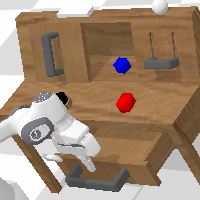
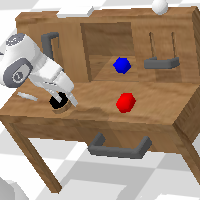
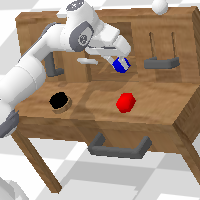
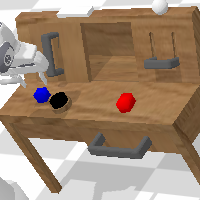
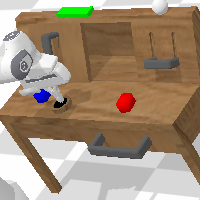
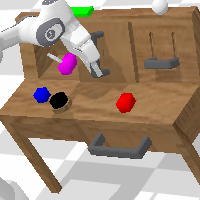
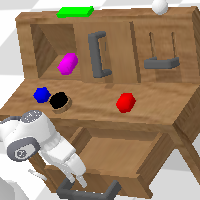
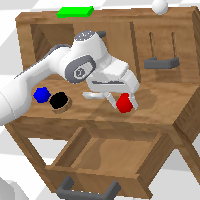
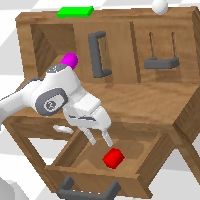
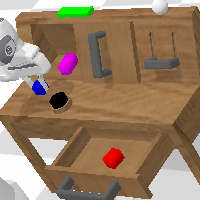
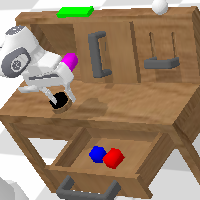
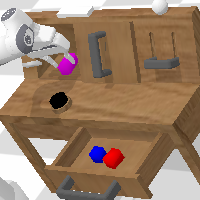
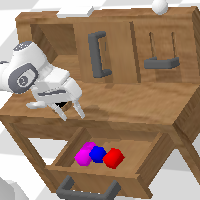
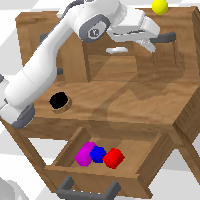
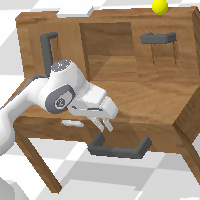

In [3]:
start_idx = (
    np.load(VAL_DATASET_PATH + "ep_start_end_ids.npy")[VAL_EPISODE_IDX, 0] + START_STEP
)


val_observations = []
images = []
robot_obs, scene_obs = None, None
for s in range(start_idx, start_idx + sum(GOAL_STEP_STRIDES) + 1):
    x = np.load(VAL_DATASET_PATH + f"/episode_{str(s).zfill(7)}.npz")
    if s == start_idx:
        robot_obs, scene_obs = x["robot_obs"], x["scene_obs"]
    val_observations.append(np.concatenate([x["robot_obs"], x["scene_obs"]]))
    images.append(x["rgb_static"])
goals = [val_observations[idx] for idx in np.cumsum(GOAL_STEP_STRIDES)]


mediapy.show_images(
    [images[0]] + [images[idx] for idx in np.cumsum(GOAL_STEP_STRIDES)],
    titles=["Initial state"]
    + [f"Goal {idx + 1}" for idx in range(len(GOAL_STEP_STRIDES))],
    columns=6,
)

These helper functions will be used to sample actions from the policy, as well as to sample plans from the conditional prior (not necessary if it is a Play-GCBC policy).

In [4]:
@eqx.filter_jit
def policy_act(
    model: PlayLMP,
    obs: Array,
    goal: Array,
    plan: Array,
    key: Array,
    state: PyTree,
) -> tuple[Array, PyTree]:
    action, new_state = model.policy.act(
        preprocess_observation(obs, observation_stats[0], observation_stats[1]),
        preprocess_observation(goal, observation_stats[0], observation_stats[1]),
        plan,
        key,
        state,
    )
    return action, new_state


@eqx.filter_jit
def sample_plan(model: PlayLMP, obs: Array, goal: Array, key: Array) -> Array:
    sampling_params = model.plan_proposal(
        preprocess_observation(obs, observation_stats[0], observation_stats[1]),
        preprocess_observation(goal, observation_stats[0], observation_stats[1]),
    )
    plan = model.sample_plan(sampling_params, key)
    return plan

Execute the policy rollout, storing the static RGB images for visualization:

In [ ]:
from calvin_env.calvin_env.envs.play_table_env import get_env

env = get_env(
    VAL_DATASET_PATH,
    obs_space={"rgb_obs": ["rgb_static"], "depth_obs": []},
    show_gui=False,
)

state = model.policy.reset()
obs = env.reset(robot_obs=robot_obs, scene_obs=scene_obs)

frames = []
goal_frames = []
key = jax.random.PRNGKey(RANDOM_SEED)

goal_idx = 0
goal_step_count = 0

plan = jnp.zeros(0)
for step in range(sum(GOAL_SWITCH_STRIDES)):
    if step in list(np.cumsum(GOAL_SWITCH_STRIDES)):
        goal_idx += 1
        goal_step_count = 0

    observation = jnp.concatenate([obs["robot_obs"], obs["scene_obs"]])

    goal = val_observations[np.cumsum(GOAL_STEP_STRIDES)[goal_idx]]
    if goal_step_count % REPLAN_EVERY_N_STEPS == 0:
        state = model.policy.reset()
        if model.plan_proposal.d_latent > 0:
            # If we are using a Play-GCBC policy (model.plan_proposal.d_latent == 0), we do not need
            # to sample a plan. Otherwise, we are using a Play-LMP policy, so we need to sample a plan
            # from the CVAE's prior.
            key, sampling_key = jax.random.split(key)
            plan = sample_plan(model, observation, goal, sampling_key)

    key, sampling_key = jax.random.split(key)
    action, state = policy_act(
        model,
        observation,
        goal,
        plan,
        sampling_key,
        state,
    )
    action = postprocess_action(
        action, action_stats[0], action_stats[1], target_max, target_min
    )
    action = action.at[-1].set(1 if action[-1] > 0 else -1)  # Binary gripper action
    obs, *_ = env.step({"action": np.asarray(action), "type": "cartesian_rel"})
    frames.append(obs["rgb_obs"]["rgb_static"])
    goal_frames.append(images[np.cumsum(GOAL_STEP_STRIDES)[goal_idx]])
    goal_step_count += 1

In [7]:
mediapy.show_videos([frames, goal_frames], titles=["Policy rollout", "Goal state"])